In [1]:
#importing libraries
import pandas as pd
import json
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.io.json import json_normalize 
import os, json
import pandas as pd
## Cell computation timer
%load_ext autotime

def flatten_json(y):
    out = {}

    def flatten(x, name=''):
        if type(x) is dict:
            for a in x:
                flatten(x[a], name + a + '_')
        elif type(x) is list:
            i = 0
            for a in x:
                flatten(a, name + str(i) + '_')
                i += 1
        else:
            out[name[:-1]] = x
    flatten(y)
    return out

# || 2. Declare test data locations

A2=[]

json_files=[]

Data_Loc = r'C:\Users\Home\Documents\Second Spectrum Everton Project\Short Goal Kicks Project\everton_event_data'

for filename_with_ext in os.listdir(Data_Loc):
    
    if (filename_with_ext.endswith(".json")):  
        
        # get the file name without the extension
        filename = filename_with_ext.split('.')[0]
        json_files.append(filename)       

#json_files=json_files[7:10]

Events3=[]
Tactical_shift2=[]
Regular_Play2=[]
Counter_Attack2=[]
Corner2=[]
GoalKicks2=[]

for file in json_files:
    

# Reading the Events File
    f = open (r'C:\Users\Home\Documents\Second Spectrum Everton Project\Short Goal Kicks Project\everton_event_data/'+str(file)+'.json') 

    # Reading from file 
    data = json.loads(f.read()) 
    data1=flatten_json(data[0])
    D=[]

    for index, value in data1.items():

        B=value
        #A=A.replace("'", '"')
        #B=A.replace("True", 'true')
        #B=B.replace("False", 'false')

        try:
            C=json.loads(B)
            for i in C:
                i["index"]=index
        except:
            continue
        D.extend(C)    
    events = pd.concat([pd.DataFrame(D)])
    events['match_id']=str(file)

    #Applying a function to split the column stored as a dictionary and then use the concat function to bring back the columns into
    #the dataframe
    type1 = events.type.apply(pd.Series).set_axis(['type_id','type_name'], axis=1, inplace=False)
    possession_team = events.possession_team.apply(pd.Series).set_axis(['possession_id', 'possession_name'], axis=1, inplace=False)
    play_pattern = events.play_pattern.apply(pd.Series).set_axis(['play_pattern_id', 'play_pattern_name'], axis=1, inplace=False)
    pass_type=events['pass'].apply(pd.Series)
    play_type = pass_type.type.apply(pd.Series).set_axis(['','play_id', 'play_type'], axis=1, inplace=False)
    pass_type=pd.concat([pass_type.drop(['type'], axis=1), play_type], axis=1)
    del pass_type[0]
    team = events.team.apply(pd.Series).set_axis(['team_id', 'team_name'], axis=1, inplace=False)
    location = events.location.apply(pd.Series).set_axis(['x', 'y','z'], axis=1, inplace=False).fillna(0)
    player = events.player.apply(pd.Series).set_axis(['','player_id', 'player_name'], axis=1, inplace=False).fillna(0)
    position = events.position.apply(pd.Series).set_axis(['','position_id', 'position_name'], axis=1, inplace=False).fillna(0).drop(player.columns[0], axis = 1) 
    events1=pd.concat([events.drop(['type'], axis=1), type1], axis=1)
    events2=pd.concat([events1.drop(['possession_team'], axis=1), possession_team], axis=1)
    events3=pd.concat([events2.drop(['play_pattern'], axis=1), play_pattern], axis=1)
    events4=pd.concat([events3.drop(['team'], axis=1), team], axis=1)
    events5=pd.concat([events4.drop(['location'], axis=1), location], axis=1)
    events6=pd.concat([events5.drop(['player'], axis=1), player], axis=1)
    events7=pd.concat([events6.drop(['position'], axis=1), position], axis=1)
    events8=pd.concat([events7.drop(['pass'], axis=1), pass_type], axis=1)
    Start_events=[35,18]
    events = events8[~(events8['type_id'].isin(Start_events))].reset_index(drop=True)

    #Where do the next actions Go?
    events['next_event']=events['type_name'].shift(-1)
    events['next_event1']=events['type_name'].shift(-2)
    events['next_player']=events['player_name'].shift(-1)
    events['next_player1']=events['player_name'].shift(-2)
    #First action of sequence
    events['next_x']=events['x'].shift(-1).fillna(0)
    events['next_y']=events['y'].shift(-1).fillna(0)


    events['Team']=np.where(events['team_name']=='Everton','Everton','Opposition')

    #Normalizing Time in seconds and minutes
    events['time']=events['minute']+events['second']/60
    events.time=round(events.time,2)
    events['seconds']=events['minute']*60+events['second']
    
    
    bins = [-5,20,40,60,90,130]
    
    labels = ["H1","H2","H3","H4","H5"]
    events['H_zone']= pd.cut(events['x'], bins=bins, labels=labels)
    bins1 = [-5,13.84,54.16,80]
    labels1 = ["V1","V2","V3"]
    events['V_zone']= pd.cut(events['y'], bins=bins1, labels=labels1)
    
    #events['V_zone']=np.where(events['x']>60,events['V_zone']=='V4',events['V_zone'])
    events['zone_combo']=events['V_zone'].astype(str)+events['H_zone'].astype(str)
    
    col= 'zone_combo'
    conditions= [events[col] == 'V3H1', events[col] == 'V3H2', events[col] == 'V3H3',
                events[col] == 'V2H1',events[col] == 'V2H2',events[col] == 'V2H3',
                events[col] == 'V1H1',events[col] == 'V1H2',events[col] == 'V1H3',
                events[col] == 'V1H4',events[col] == 'V2H4',events[col] == 'V3H4',
                events[col] == 'V1H5',events[col] == 'V2H5',events[col] == 'V3H5']
    choices= [1, 2,3,4,5,6,7,8,9,10,10,10,11,11,11]

    events["zone_final"] = np.select(conditions, choices, default=0)
    events["zone_final1"] = events["zone_final"].shift(-1).fillna(0)
    ### Look ahead by 10 actions ####
    
    #events["zone_final1"] = events["zone_final0"].shift(-1).fillna(0)
    #events["zone_final2"] = events["zone_final1"].shift(-1).fillna(0)
    #events["zone_final3"] = events["zone_final2"].shift(-1).fillna(0)
    #events["zone_final4"] = events["zone_final3"].shift(-1).fillna(0)
    #events["zone_final5"] = events["zone_final4"].shift(-1).fillna(0)
    #events["zone_final6"] = events["zone_final5"].shift(-1).fillna(0)
    #events["zone_final7"] = events["zone_final6"].shift(-1).fillna(0)
    #events["zone_final8"] = events["zone_final7"].shift(-1).fillna(0)
    #events["zone_final9"] = events["zone_final8"].shift(-1).fillna(0)
    #events["zone_final10"] = events["zone_final9"].shift(-1).fillna(0)
    
    
    #Assigning Proxy associated to x-axis (three Vertical zones)
    bins = [0,40,80,121]
    labels = ["Defensive-Third","Middle-Third","Offensive-Third"]
    events['x_zone']= pd.cut(events['x'], bins=bins, labels=labels)
    events['next_x_zone']=events['x_zone'].shift(-1)
    #Second action of sequence
    events['next_x1']=events['x'].shift(-2).fillna(0)
    events['next_y1']=events['y'].shift(-2).fillna(0)
    #Third action of sequence
    events['next_x2']=events['x'].shift(-3).fillna(0)
    events['next_y2']=events['y'].shift(-3).fillna(0)
    #Fourth action of sequence
    events['next_x3']=events['x'].shift(-4).fillna(0)
    events['next_y3']=events['y'].shift(-4).fillna(0)
    #Fifth action of sequence
    events['next_x4']=events['x'].shift(-5).fillna(0)
    events['next_y4']=events['y'].shift(-5).fillna(0)
    
  

    bins1 = [0,12,24,55,68,80]
    labels1 = ["Right","Right-Half-Space","Middle","Left-Half-Space","Left"]
    events['y_zone']= pd.cut(events['y'], bins=bins1, labels=labels1)
    events['next_y_zone']=events['y_zone'].shift(-1)
    #Subsetting data for open play and closed play
    events['play_pattern_count'] = events.groupby((events['play_pattern_name'] != events['play_pattern_name'].shift(1)).cumsum()).cumcount()+1
    events['play_pattern_name1']=events['play_pattern_name'].shift(-1)
    #Subsetting times for Goal Kicks, Corner Kicks, Free Kicks to sync with tracking data: #Miscellaneous Information

    def add_distance_to_ball(events):

        events['distance'] = events[['x', 'y']].sub(np.array(events[['next_x', 'next_y']] )).pow(2).sum(1).pow(0.5)
        events.distance = events.distance.round(2)
        return(events)

    events=add_distance_to_ball(events)

    ################### Only look at shots ###################
    Events=events
    Shots=Events[Events['type_name']=='Shot'].reset_index(drop=True)

    D=[]

    for index, row in Shots.iterrows():

        A=row['shot']
        C=pd.DataFrame.from_dict(A,orient='index')
        C=C.T
        D.append(C)
        
    D=pd.concat(D).reset_index(drop=True)
    Events1=pd.merge(Shots,D[['statsbomb_xg']],left_index=True,right_index=True)
    Events2=pd.merge(Events1[['id','statsbomb_xg']],Events,on='id',how='right')
    
    ###### Keep only columns in list ########
    
    cols_list=['id','statsbomb_xg','timestamp','minute','second','duration','match_id','type_name','possession_name','play_pattern_name','team_name','x','y','z','player_id','player_name','position_id','position_name','height','outcome','recipient','play_type','next_event','next_event1','next_player','next_player1','next_x','next_y','time','x_zone','next_x_zone','next_x1','next_y1',
               'next_x2','next_y2','next_x3','next_y3','next_x4','next_y4','y_zone','next_y_zone','play_pattern_count','distance','zone_final','zone_final1']
    Events2=Events2[cols_list].reset_index(drop=True)
    
    
    ##### Getting all the other phases of play #####
    
    GoalKicks1=Events2[(Events2['play_pattern_name']=='From Goal Kick')]
    Corner1=Events2[Events2['play_pattern_name']=='From Corner']
    FreeKicks1=Events2[Events2['play_pattern_name']=='From Free Kick']
    Counter_Attack1=Events2[Events2['play_pattern_name']=='From Counter']
       

    ##### Appending the event datasets from matches #####
    
    #Regular_Play2.append(Regular_Play1)
    Counter_Attack2.append(Counter_Attack1)
    Corner2.append(Corner1)
    GoalKicks2.append(GoalKicks1)

    Events3.append(Events2)
    #Events2.to_csv(r'C:\Users\Home\Documents\Second Spectrum Everton Project\Short Goal Kicks Project\everton event data converted/'+str(file)+'.csv')

##### Points to remember ######
1) play pattern count will start at 1 every time play type is Goal Kick
2) Have to identify time when zone 10 has been breached 
3) Create a matrix of zone interactions
4) Number of offensive actions until team reaches opposition half 
5) Subset short goal kicks using height indicator (High/Low Pass) 

In [50]:
#Creating DataFrames from the lists
GoalKicks3=pd.concat(GoalKicks2)
#Events3=pd.concat(Events3)

time: 97.9 ms


In [58]:
notin=[0,10,11,3,6,9]

GK1=GoalKicks3[(GoalKicks3['play_type']=='Goal Kick') & (~GoalKicks3['zone_final1'].isin(notin))
              & (GoalKicks3['next_event']=='Ball Receipt*')].reset_index(drop=True)

time: 10.1 ms


In [59]:
GK1=GoalKicks3[(GoalKicks3['play_type']=='Goal Kick')].reset_index(drop=True)
GK1['sequence']=GK1.index

print(len(GK1))
print(len(GK1))

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.
 54.]
time: 44 ms


In [ ]:
### Subset list of sequences ###
list_of_seq=list(GK1['sequence'].unique())

#### Merge two dataframes to get sequence ids for goal kicks ####
GK2=pd.merge(GoalKicks3,GK1[['id','sequence']], on='id',how='left')
GK2['sequence']=GK2['sequence']

GK3=GK2[GK2['sequence'].isin(list_of_seq)].reset_index(drop=True)   

print(GK2['sequence'].unique())

In [71]:
A=[]
B=[]
C=[]

for i in list_of_seq:
    
    Subset=Subset.sort_values(['time'], ascending=[True])
    Subset=GK3[GK3['sequence']==21].reset_index(drop=True)
    #Subset=GK3[GK3['sequence']==i].reset_index(drop=True)
    Subset['rolling']=Subset['time'].rolling(window=2).apply(lambda x: x.iloc[1] - x.iloc[0]).fillna(0)
    Subset['cumsum'] = Subset['rolling'].cumsum()
    rolling=Subset[['sequence','play_pattern_count','rolling','zone_final','cumsum',
                    'position_name','type_name','player_name','time','team_name','play_type']]
    
rolling

sequence  play_pattern_count  rolling  zone_final  cumsum  \
0       21.0                   1     0.00           4    0.00   
1       21.0                   2     0.00           4    0.00   
2       21.0                   3     0.01           4    0.01   
3       21.0                   4     0.02           4    0.03   
4       21.0                   5     0.03           4    0.06   
5       21.0                   6     0.05          10    0.11   
6       21.0                   7     0.00          10    0.11   
7       21.0                   8     0.00           3    0.11   
8       21.0                   9     0.04          10    0.15   
9       21.0                  10     0.00           2    0.15   
10      21.0                  11     0.05          10    0.20   
11      21.0                  12     0.00           6    0.20   
12      21.0                   1     2.61           4    2.81   
13      21.0                   2     0.07          10    2.88   
14      21.0                   3     0.00           2    2.88   
15      21.0                   4     0.00          10    2.88   
16      21.0                   5     0.02          10    2.90   
17      21.0                   6     0.01          10    2.91   
18      21.0                   7     0.00          10    2.91   
19      21.0                   8     0.00          10    2.91   
20      21.0                   9     0.00          10    2.91   
21      21.0                  10     0.00          10    2.91   
22      21.0                  11     0.02           6    2.93   
23      21.0                  12     0.00          10    2.93   
24      21.0                  13     0.00           6    2.93   
25      21.0                  14     0.02          10    2.95   
26      21.0                  15     0.00          10    2.95   
27      21.0                  16     0.03          10    2.98   
28      21.0                  17     0.05          11    3.03   
29      21.0                  18     0.00          11    3.03   
30      21.0                  19     0.00           1    3.03   
31      21.0                  20     0.05           1    3.08   
32      21.0                  21     0.00           1    3.08   
33      21.0                  22     0.02           1    3.10   
34      21.0                  23     0.03          10    3.13   
35      21.0                  24     0.02           3    3.15   
36      21.0                   1     0.91           4    4.06   

                position_name      type_name                   player_name  \
0                  Goalkeeper           Pass               Jordan Pickford   
1            Left Center Back  Ball Receipt*                 Mason Holgate   
2            Left Center Back           Pass                 Mason Holgate   
3                  Goalkeeper  Ball Receipt*               Jordan Pickford   
4                  Goalkeeper           Pass               Jordan Pickford   
5         Left Center Forward  Ball Receipt*         Dominic Calvert-Lewin   
6         Left Center Forward           Pass         Dominic Calvert-Lewin   
7                  Right Back           Duel                  James Justin   
8        Right Center Forward  Ball Receipt*                Anthony Gordon   
9           Right Center Back           Pass                   Jonny Evans   
10      Right Center Midfield  Ball Receipt*                James Maddison   
11                Center Back  Ball Recovery  Yerry Fernando Mina González   
12                 Goalkeeper           Pass               Jordan Pickford   
13       Right Center Forward  Ball Receipt*                Anthony Gordon   
14          Right Center Back           Pass                   Jonny Evans   
15       Right Center Forward           Duel                Anthony Gordon   
16      Right Center Midfield           Pass    André Filipe Tavares Gomes   
17  Center Defensive Midfield  Ball Receipt*                    Tom Davies   
18  Center Defensive Midfield          Carry       

time: 1.37 s


In [32]:
GK3.play_type.unique()

array(['Goal Kick', nan, 'Recovery', 'Interception'], dtype=object)

time: 8.5 ms


In [12]:
Subset.time.unique()

array([92.08, 92.1 , 92.12, 92.15, 92.27, 92.28, 92.35, 92.38, 92.4 ,
       92.43, 92.5 , 92.53, 92.55, 92.57, 92.58, 92.6 , 92.63, 92.65,
       92.67, 92.7 , 92.72, 92.73, 92.77, 92.78, 92.8 , 92.88, 92.9 ,
       92.95, 92.98, 93.02, 93.03, 93.08, 93.1 , 93.15, 93.18, 93.22,
       93.23])

time: 5.42 ms


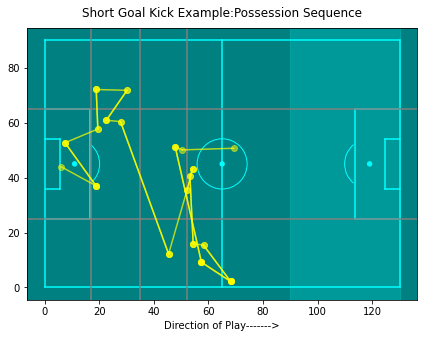

time: 502 ms


In [9]:
from matplotlib.patches import Arc

#Where does the keeper pass to from Goal Kicks?
#GK3=GK2[GK2['sequence']==45][:1]
GoalKicks_receipts=Subset[Subset['type_name']=='Pass'][:10]

#Create figure
fig=plt.figure()
fig.set_size_inches(7, 5)
ax=fig.add_subplot(1,1,1)
plt.rcParams['axes.facecolor'] = 'Cyan'
ax.set_facecolor('teal')

#Pitch Outline & Centre Line
plt.plot([0,0],[0,90], color="cyan")
plt.plot([0,130],[90,90], color="cyan")
plt.plot([130,130],[90,0], color="cyan")
plt.plot([130,0],[0,0], color="cyan")
plt.plot([65,65],[0,90], color="cyan")

#Left Penalty Area
plt.plot([16.5,16.5],[65,25],color="cyan")
plt.plot([0,16.5],[65,65],color="cyan")
plt.plot([16.5,0],[25,25],color="cyan")

#Right Penalty Area
plt.plot([130,113.5],[65,65],color="cyan")
plt.plot([113.5,113.5],[65,25],color="cyan")
plt.plot([113.5,130],[25,25],color="cyan")

#Left 6-yard Box
plt.plot([0,5.5],[54,54],color="cyan")
plt.plot([5.5,5.5],[54,36],color="cyan")
plt.plot([5.5,0.5],[36,36],color="cyan")

#Right 6-yard Box
plt.plot([130,124.5],[54,54],color="cyan")
plt.plot([124.5,124.5],[54,36],color="cyan")
plt.plot([124.5,130],[36,36],color="cyan")

#Prepare Circles
centreCircle = plt.Circle((65,45),9.15,color="cyan",fill=False)
centreSpot = plt.Circle((65,45),0.8,color="cyan")
leftPenSpot = plt.Circle((11,45),0.8,color="cyan")
rightPenSpot = plt.Circle((119,45),0.8,color="cyan")

#Draw Circles
ax.add_patch(centreCircle)
ax.add_patch(centreSpot)
ax.add_patch(leftPenSpot)
ax.add_patch(rightPenSpot)
plt.axvline(x=35,color="grey")
plt.axvline(x=52,color="grey")
plt.axvline(x=17,color="grey")

plt.axhline(y=25,color="grey")
plt.axhline(y=65,color="grey")
#plt.axhline(y=54,alpha=0.1,color="black")
#plt.axhline(y=74,alpha=0.1,color="black")


#Prepare Arcs
leftArc = Arc((11,45),height=18.3,width=18.3,angle=0,theta1=310,theta2=50,color="cyan")
rightArc = Arc((119,45),height=18.3,width=18.3,angle=0,theta1=130,theta2=230,color="cyan")

#Draw Arcs
ax.add_patch(leftArc)
ax.add_patch(rightArc)

#Tidy Axes
#plt.axis('off')
#plt.xticks([])
#plt.yticks([])

#for i in range(len(GoalKicks_receipts)):
               
#for i in range(number_of_colors):

plt.plot([(GoalKicks_receipts["x"]),(GoalKicks_receipts["next_x"])],[(GoalKicks_receipts["y"]),(GoalKicks_receipts["next_y"])], color='yellow',alpha=0.7)
plt.plot([(GoalKicks_receipts["next_x"]),(GoalKicks_receipts["next_x1"])],[(GoalKicks_receipts["next_y"]),(GoalKicks_receipts["next_y1"])], color='yellow',alpha=0.7)
plt.plot([(GoalKicks_receipts["next_x1"]),(GoalKicks_receipts["next_x2"])],[(GoalKicks_receipts["next_y1"]),(GoalKicks_receipts["next_y2"])], color='yellow',alpha=0.7)
plt.plot([(GoalKicks_receipts["next_x2"]),(GoalKicks_receipts["next_x3"])],[(GoalKicks_receipts["next_y2"]),(GoalKicks_receipts["next_y3"])], color='yellow',alpha=0.7)
plt.plot((GoalKicks_receipts["next_x"]),(GoalKicks_receipts["next_y"]),"o", color="yellow",alpha=0.5)
plt.plot((GoalKicks_receipts["x"]),(GoalKicks_receipts["y"]),"o", color="yellow",alpha=0.5)
plt.plot((GoalKicks_receipts["next_x1"]),(GoalKicks_receipts["next_y1"]),"o", color="yellow",alpha=0.5)
plt.plot((GoalKicks_receipts["next_x2"]),(GoalKicks_receipts["next_y2"]),"o", color="yellow",alpha=0.5)
plt.plot((GoalKicks_receipts["next_x3"]),(GoalKicks_receipts["next_y3"]),"o", color="yellow",alpha=0.5)
plt.axvspan(90, 130, alpha=0.2, color='cyan')
plt.xlabel('Direction of Play------->')
plt.title("Short Goal Kick Example:Possession Sequence", y=1.02);#x = GoalKicks_receipts.x.values*1.083


#Display Pitch
plt.show()

In [40]:
GoalKicks3.to_csv(r'C:\Users\Home\Documents\D.csv')

time: 261 ms


##### Add later on if necessary ####


In [ ]:
 ### Look ahead by 10 actions ####
    
    #events["zone_final1"] = events["zone_final0"].shift(-1).fillna(0)
    #events["zone_final2"] = events["zone_final1"].shift(-1).fillna(0)
    #events["zone_final3"] = events["zone_final2"].shift(-1).fillna(0)
    #events["zone_final4"] = events["zone_final3"].shift(-1).fillna(0)
    #events["zone_final5"] = events["zone_final4"].shift(-1).fillna(0)
    #events["zone_final6"] = events["zone_final5"].shift(-1).fillna(0)
    #events["zone_final7"] = events["zone_final6"].shift(-1).fillna(0)
    #events["zone_final8"] = events["zone_final7"].shift(-1).fillna(0)
    #events["zone_final9"] = events["zone_final8"].shift(-1).fillna(0)
    #events["zone_final10"] = events["zone_final9"].shift(-1).fillna(0)
    
    
    #Assigning Proxy associated to x-axis (three Vertical zones)
    #bins = [0,40,80,121]
    labels = ["Defensive-Third","Middle-Third","Offensive-Third"]
    events['x_zone']= pd.cut(events['x'], bins=bins, labels=labels)
    events['next_x_zone']=events['x_zone'].shift(-1)
    #Second action of sequence
    events['next_x1']=events['x'].shift(-2).fillna(0)
    events['next_y1']=events['y'].shift(-2).fillna(0)
    #Third action of sequence
    events['next_x2']=events['x'].shift(-3).fillna(0)
    events['next_y2']=events['y'].shift(-3).fillna(0)
    #Fourth action of sequence
    events['next_x3']=events['x'].shift(-4).fillna(0)
    events['next_y3']=events['y'].shift(-4).fillna(0)
    #Fifth action of sequence
    events['next_x4']=events['x'].shift(-5).fillna(0)
    events['next_y4']=events['y'].shift(-5).fillna(0)
    
  

    bins1 = [0,12,24,55,68,80]
    labels1 = ["Right","Right-Half-Space","Middle","Left-Half-Space","Left"]
    events['y_zone']= pd.cut(events['y'], bins=bins1, labels=labels1)
    events['next_y_zone']=events['y_zone'].shift(-1)
    #Subsetting data for open play and closed play
    events['play_pattern_count'] = events.groupby((events['play_pattern_name'] != events['play_pattern_name'].shift(1)).cumsum()).cumcount()+1
    events['play_pattern_name1']=events['play_pattern_name'].shift(-1)
    #Subsetting times for Goal Kicks, Corner Kicks, Free Kicks to sync with tracking data: #Miscellaneous Information
